In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pandas.read_csv(csv_path)

In [4]:
housing = load_housing_data()
# housing.head()


In [5]:
# housing.info()

In [6]:
# housing["ocean_proximity"].value_counts()

In [7]:
# housing.describe()

In [8]:
import matplotlib.pyplot as plot

# %matplotlib inline
# housing.hist(bins=50, figsize=(20,15))
# plot.show()

In [9]:
import numpy

def split_train_test(data, test_ratio):
    shuffled_indices = numpy.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    # crc32 returns unsigned int, 0xffffffff ensures comptab w/ py 2 & 3 by normalizing value
    # then it tests that it's lower than ratio value
    return crc32(numpy.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    print(ids)
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    print(in_test_set)
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()

In [13]:
# housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
housing["income_cat"] = pandas.cut(housing["median_income"], 
                                   bins=[0., 1.5, 3.0, 4.5, 6., numpy.inf], labels=[1,2,3,4,5])

In [16]:
# housing["income_cat"].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
# Verify that sampling is same as income category proportions 
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
# housing["income_cat"].value_counts() / len(housing)

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [21]:
housing = strat_train_set.copy()
# housing.plot(kind="scatter", x="longitude", y="latitude")
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

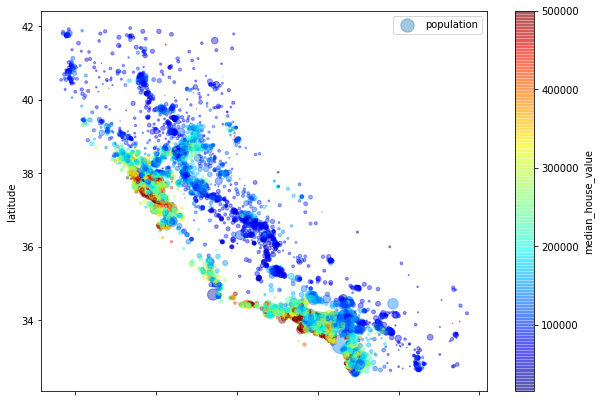

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plot.get_cmap("jet"), colorbar=True)
plot.legend()

In [23]:
correlation_matrix = housing.corr()

In [24]:
# sort correlation coefficient (linear correlations) of median house values
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [25]:
from pandas.plotting import scatter_matrix
#scatter_matrix plots attributes against other attributes
# attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12, 8))

In [26]:
# housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [28]:
# correlation_matrix = housing.corr()
# correlation_matrix["median_house_value"].sort_values(ascending=False)

In [29]:
housing=strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy() 

In [30]:
from sklearn.impute import SimpleImputer

#Replace missing values with the median
imputer = SimpleImputer(strategy="median")
# remove ocean_proximity since its text & median needs numerical attributes only
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [31]:
#imputer computes median of each attribute & stores it in statistics_
# check that imputer values & train set are equal to see if values are missing
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [32]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [33]:
# transforms training set by replacing missing missing values with learned medians
X = imputer.transform(housing_num)
# results in plain NumPy array so need to put it into a pandas DataFrame

housing_tr = pandas.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [34]:
#OrdinalEncoder - turns categories into numerical values

housing_cat = housing[["ocean_proximity"]]
# print(housing_cat.head(10))

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# housing_cat_encoded[:10]


In [35]:
from sklearn.preprocessing import OneHotEncoder

# one-hot encoding
# Uses sparse array to save space

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
# housing_cat_1hot.toarray()

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return numpy.c_[X, rooms_per_household, population_per_household,
                    bedrooms_per_room]
        else:
            return numpy.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [38]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [39]:
from sklearn.linear_model import LinearRegression

# housing_labels: median prices separated from rest of data
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [40]:
# some_data = housing.iloc[:5]
# some_labels = housing_labels.iloc[:5]
# some_data_prepared = full_pipeline.transform(some_data)
# print("Predictions", lin_reg.predict(some_data_prepared))
# print("Labels", list(some_labels))


In [41]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = numpy.sqrt(lin_mse)
lin_rmse

# High error with training set so try better model

68628.19819848922

In [42]:
# train with Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [43]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = numpy.sqrt(tree_mse)
tree_rmse

# 0.0, but probably overfit the data

0.0

In [44]:
# cross validation testing with decision tree
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = numpy.sqrt(-scores)

In [45]:
def display_scores(scores):
    print("SCORES:", scores)
    print("MEAN:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

SCORES: [69495.56110104 67276.39713561 71877.41645947 68913.73500425
 72788.48081417 74666.87344539 70645.42229085 71561.21154215
 77485.6074046  70035.17056952]
MEAN: 71474.58757670483
Standard deviation: 2812.0791197817516


In [46]:
# Compare with linear regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = numpy.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# linear reg model is better than decision tree (which is overfitting)

SCORES: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
MEAN: 69052.46136345083
Standard deviation: 2731.6740017983498


In [47]:
# random forests model

from sklearn.ensemble import RandomForestRegressor
# forest_reg = RandomForestRegressor()
# forest_reg.fit(housing_prepared, housing_labels)
# housing_predictions = forest_reg.predict(housing_prepared)
# forest_mse = mean_squared_error(housing_labels, housing_predictions)
# forest_rmse = numpy.sqrt(forest_mse)
# forest_rmse

In [48]:
# forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
# forest_rmse_scores = numpy.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [50]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(max_features=6, n_estimators=30)


In [51]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(numpy.sqrt(-mean_score), params)

64748.49023905796 {'max_features': 2, 'n_estimators': 3}
55401.4428208476 {'max_features': 2, 'n_estimators': 10}
53171.57612694697 {'max_features': 2, 'n_estimators': 30}
60155.020903303106 {'max_features': 4, 'n_estimators': 3}
52859.935377580914 {'max_features': 4, 'n_estimators': 10}
50348.07963397132 {'max_features': 4, 'n_estimators': 30}
59448.442294359236 {'max_features': 6, 'n_estimators': 3}
52312.16510661042 {'max_features': 6, 'n_estimators': 10}
50007.22193646819 {'max_features': 6, 'n_estimators': 30}
58061.78435503976 {'max_features': 8, 'n_estimators': 3}
51931.8156695285 {'max_features': 8, 'n_estimators': 10}
50011.80345403242 {'max_features': 8, 'n_estimators': 30}
61893.92266552445 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54919.8861492093 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60985.02665492472 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53191.12002148315 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [52]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.31489872e-02, 6.66674520e-02, 4.41687665e-02, 1.67837530e-02,
       1.64892321e-02, 1.72075078e-02, 1.62401862e-02, 3.20914913e-01,
       4.60793535e-02, 1.08713794e-01, 9.97839538e-02, 7.53462502e-03,
       1.59481383e-01, 7.14054820e-05, 2.82522412e-03, 3.88946270e-03])

In [61]:
extra_attribs = ["rooms_per_household", "pop_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


[(0.32091491273361017, 'median_income'),
 (0.15948138328479283, 'INLAND'),
 (0.1087137944229001, 'pop_per_household'),
 (0.09978395383538019, 'bedrooms_per_room'),
 (0.0731489872401818, 'longitude'),
 (0.06666745197996234, 'latitude'),
 (0.04607935351155976, 'rooms_per_household'),
 (0.04416876645939333, 'housing_median_age'),
 (0.01720750784385237, 'population'),
 (0.01678375303653896, 'total_rooms'),
 (0.016489232109052624, 'total_bedrooms'),
 (0.016240186210333175, 'households'),
 (0.007534625024783104, '<1H OCEAN'),
 (0.003889462704856505, 'NEAR OCEAN'),
 (0.00282522412082957, 'NEAR BAY'),
 (7.140548197329093e-05, 'ISLAND')]

In [71]:
final_model = grid_search.best_estimator_

# prepare data
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
# transform, not fit_transform-which fits test set, data
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = numpy.sqrt(final_mse)
print(final_rmse)

47644.901694754495


In [74]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
numpy.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45666.44194178, 49544.41840796])